## Import libs

Note:
*   import py does not work on Colab
*   confliction tf and torch versions for parsing and cp-vton-plus requirements
* subprocess doesn't work on Colab

In [11]:
import cv2 as cv
import matplotlib.pyplot as plt
import pickle
import torch
import shutil
import numpy as np
import pandas as pd
from utils import *
from PIL import Image

import torchvision
from IPython.core.display import Video
from moviepy.editor import *
import moviepy.video.fx.all as vfx
from moviepy.video.fx.all import crop, resize
import ffmpeg

import json
import argparse
import pickle
import random
import os
import subprocess

from tqdm import tqdm
from google.colab.patches import cv2_imshow


/usr/maviswang/src


## Sys Test - custom video

1. upload videoPath, clothID
2. process video
3. process cloth
4. create pairs
5. process required inputs
6. warping cloth
7. try on overlay
8. create video

## inputs

In [3]:
# cloth index
clothID = 0

# user defined video input
video = '../data/raw/tryOnVideo_women.mp4'
showColabVideo(video)


In [4]:
Video(video)

## process data

In [5]:
def runOpenPose():
  processCloth(raw_cloth_DIR, cloth_DIR, cloth_mask_DIR)


[MoviePy] >>>> Building video ../data/processed/tryOnVideo.mp4
[MoviePy] Writing video ../data/processed/tryOnVideo.mp4


 98%|█████████▊| 40/41 [00:00<00:00, 60.59it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ../data/processed/tryOnVideo.mp4 

[MoviePy] >>>> Building video ../data/input/tryOnVideo.mp4
[MoviePy] Writing video ../data/input/tryOnVideo.mp4



 98%|█████████▊| 40/41 [00:00<00:00, 47.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../data/input/tryOnVideo.mp4 

/content/drive/MyDrive/SMFAI/lib/humanParsing
     |████████████████████████████████| 108 kB 14.2 MB/s 
Evaluating total class number 7 with ['Background', 'Head', 'Torso', 'Upper Arms', 'Lower Arms', 'Upper Legs', 'Lower Legs']
100% 39/39 [00:20<00:00,  1.92it/s]
/content/drive/MyDrive/SMFAI/src


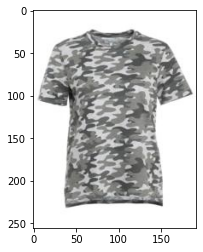

In [6]:
# CMU openPose https://github.com/CMU-Perceptual-Computing-Lab/openpose
runOpenPose()
getOpenPose(video, 0,4)
# show cloth
_=plt.imshow(cv.imread(os.path.join(cloth_DIR, \
                                    testPairsTxt(clothID, img_frames_DIR, cloth_DIR).iloc[0,1]))[:,:,::-1])

# https://github.com/GoGoDuck912/Self-Correction-Human-Parsing
%cd ../lib/humanParsing
!pip install ninja
!python parse.py --dataset 'pascal' \
--model-restore 'model_Schp_pascal.pth' \
--input-dir '../../data/processed/image' \
--output-dir 'pascal'

# read processed inputs
%cd ../../src
getSCHP()

## try on - cp-vton-plus

In [7]:
# warping
tryOnInputGen(cpVtonPlusDIR)
%cd ../lib/cpVtonPlus
!pip install tensorboardX
!pip install torchvision==0.2.1
!python test.py --name 'GMM' \
--gpu_ids 'None' \
--batch-size 4 \
--dataroot 'data' \
--datamode 'test' \
--stage 'GMM' \
--data_list 'testPairs.txt' \

# move GMM output to TOM input
src_warp_cloth = 'result/GMM/test/warp-cloth'
src_warp_mask = 'result/GMM/test/warp-mask'
dest_warp_cloth = 'data/test/warp-cloth'
dest_warp_mask = 'data/test/warp-mask'
if os.path.exists(dest_warp_cloth):
    shutil.rmtree(dest_warp_cloth)
if os.path.exists(dest_warp_mask):
    shutil.rmtree(dest_warp_mask)
shutil.copytree(src_warp_cloth, dest_warp_cloth)
shutil.copytree(src_warp_mask, dest_warp_mask)

# try on
!python test.py \
--name TOM \
--stage TOM \
--workers 2 \
--datamode test \
--data_list testPairs.txt \
--checkpoint models/tom_final.pth

/content/drive/My Drive/SMFAI/lib/cpVtonPlus
     |████████████████████████████████| 125 kB 5.2 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111


Namespace(batch_size=4, checkpoint='models/gmm_final.pth', data_list='testPairs.txt', datamode='test', dataroot='data', display_count=1, fine_height=256, fine_width=192, gpu_ids='None', grid_size=5, name='GMM', radius=5, result_dir='result', shuffle=False, stage='GMM', tensorboard_dir='tensorboard', workers=1)
Start to test stage: GMM, named: GMM!
initialization method [normal]
initialization method [normal]
step:        1, time: 14.483
step:        2, time: 10.532
step:        3, time: 10.082
step:        4, time: 10.029
step:        5, time: 8.426
step:        6, time: 8.631
step:        7, time: 9.787
step:        8, time: 11.807
step:        9, time: 22.210
step:       10, time: 8.647
Finished test GMM, named: GMM!
Namespace(batch_size=4, checkpoint='models/tom_final.pth', data_list='testPairs.txt', datamode='test', dataroot='data', display_count=1, fine_height=256, fine_width=192, gpu_ids='', grid_size=5, name='TOM', radius=5, result_dir='result', shuffle=False, stage='TOM', tenso

In [8]:
#result
%cd ../../src
out_video = getTryOnVideo(out_tryOn_DIR)
showColabVideo(out_video)

/content/drive/MyDrive/SMFAI/src
[MoviePy] >>>> Building video ../result/out_tryOnVideo_0.mp4
[MoviePy] Writing video ../result/out_tryOnVideo_0.mp4


100%|██████████| 40/40 [00:00<00:00, 55.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../result/out_tryOnVideo_0.mp4 



In [9]:
Video(out_video)